# Variational Autoencoders

After doing the exercises below, you will be able to:
- Train convolutional VAEs using the reparametrization trick.
- Generete new, unseen data by sampling from the latent space.
- Illustrate interpolation between different images thanks to latent representations.
- Visualize the effect of different weights on the regularization term on the learnt latent space.

**Warning!** If you have issues with the library imports, do not hesitate to use Google Colab instead.

## Library Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## The MNIST dataset
The following coad loads the MNIST dataset and builds the necessary dataloaders for training.

In [2]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## 1. Define the VAE class
In this section we will define the VAE class that we will train and use for image generation. We make the choice of training a Convolutional VAE, with the following architecture (once more, we leave the number of hidden dimensions $p$ as a free parameter):
- **The Encoder:** The encoder will consist of the following layers:
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer

- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two paraller fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.

- **The Decoder.** The decoder will consist of the following layers:
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

In [4]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  #pour forcer à avor des valeurs positives, on prend le log de var et non pas var
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    #TO DO
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
# %load solutions/conv_vae.py


## 2. Define the loss function

In [19]:
# TODO: Implement the loss function
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') #terme de reconstruction (noir et blanc contraste sinon mse)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #envoyer sur une loi normale
    return BCE + beta * KLD

In [5]:
# %load solutions/vae_loss.py

## 3. Train the VAE
In order to be able to visualize the latent space of the VAE, we will choose a latent dimension equal to 2.

In [ ]:
# Hyperparameters
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

# TODO: Initialize the VAE model and the Adam optimizer
# and move the model to the device

# TODO: Train the model for the given number of epochs
# At the end of each epoch, print the training loss

In [20]:
# %load solutions/train_vae.py
# Hyperparameters
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

# Initialize the VAE model and the Adam optimizer
vae = ConvVAE(latent_dim=latent_dim)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Train the model for the given number of epochs
# At the end of each epoch, print the training loss
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #running_test_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 193.9811
Epoch 2, Training loss: 160.0892
Epoch 3, Training loss: 156.0137
Epoch 4, Training loss: 153.3634
Epoch 5, Training loss: 151.5070
Epoch 6, Training loss: 150.3935
Epoch 7, Training loss: 149.1944
Epoch 8, Training loss: 148.4590
Epoch 9, Training loss: 147.6342
Epoch 10, Training loss: 147.1458
Epoch 11, Training loss: 146.4361
Epoch 12, Training loss: 146.0596
Epoch 13, Training loss: 145.6682
Epoch 14, Training loss: 145.2356
Epoch 15, Training loss: 144.9344
Epoch 16, Training loss: 144.6360
Epoch 17, Training loss: 144.2381
Epoch 18, Training loss: 143.9389
Epoch 19, Training loss: 143.6787
Epoch 20, Training loss: 143.3300
Epoch 21, Training loss: 143.2436
Epoch 22, Training loss: 143.0595
Epoch 23, Training loss: 142.6642
Epoch 24, Training loss: 142.5235
Epoch 25, Training loss: 142.3807
Epoch 26, Training loss: 142.1998
Epoch 27, Training loss: 142.0018
Epoch 28, Training loss: 141.8360
Epoch 29, Training loss: 141.7720
Epoch 30, Training loss

## 4. Visualize the results
We first check if the vae model has learnt meaningful features, by plotting a bunch of images from the test set along with their respective reconstructions.

We have already define a function called `image_comparison` in the previous noteboo, that does exactly what we want. We can either copy paste it below, or better yet, create a file in the current folder called `utils.py`, copy-paste the function there, along with all the necessary library imports, and then import the `image_comparison` function in the cell below.

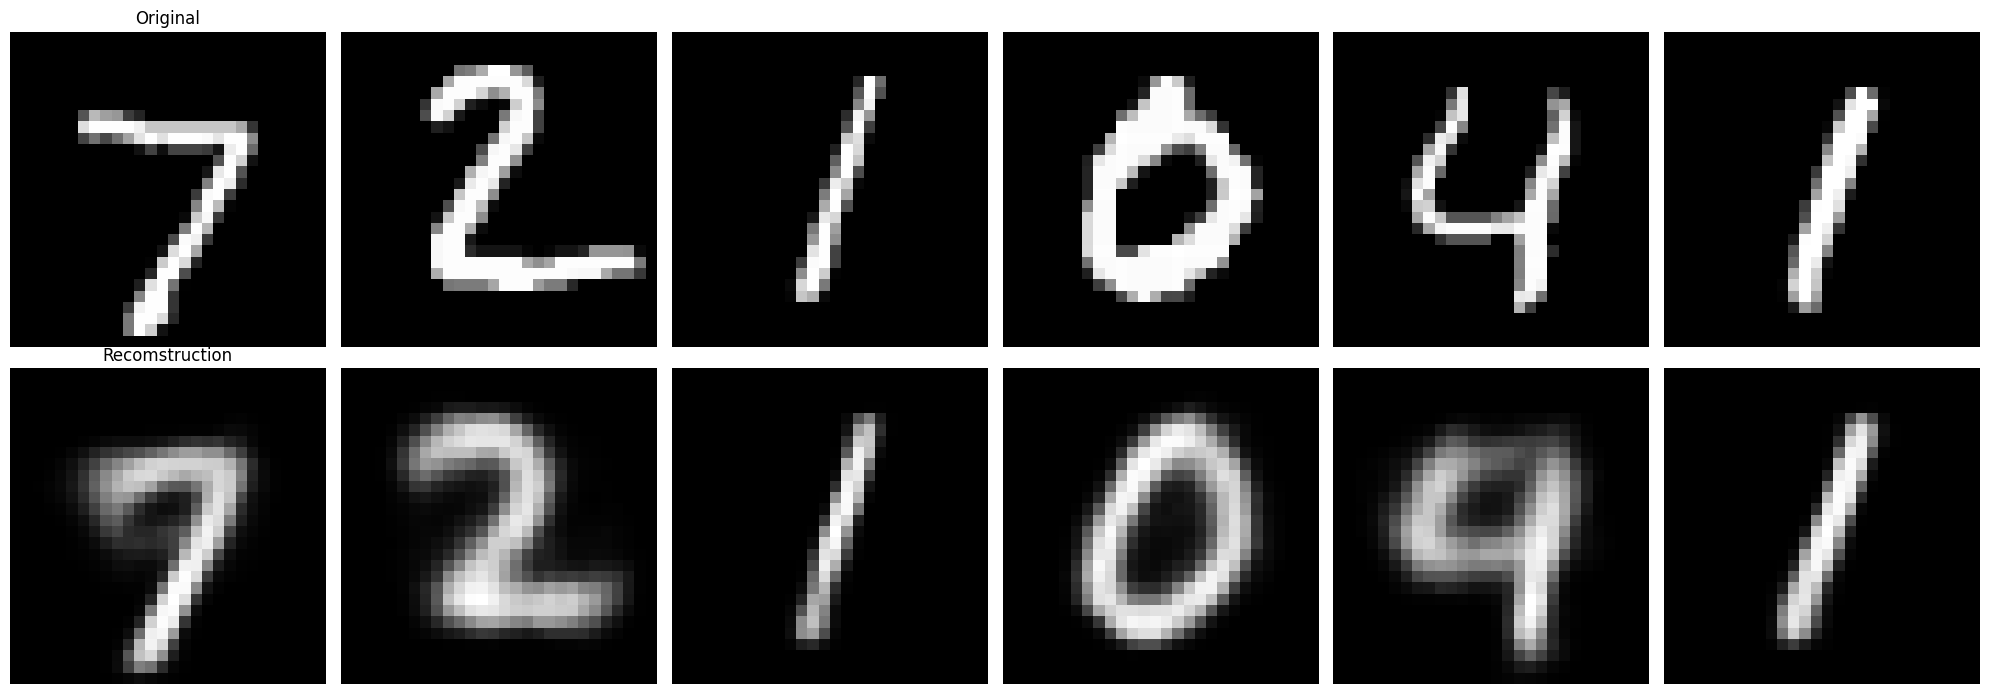

In [16]:
# TODO: Define or import the image_comparison function
from utils import image_comparison 
# Select a batch of images from the test dataset
random_images = next(iter(test_loader))

# Get the reconstructions of the selected images
recons, _, _ = vae(random_images[0].to(device))

# Reshape the images for plotting
random_images = random_images[0].cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

## 5. Image generation
The puropose of this section is to generate new images that look like MNIST digits. In order to do so, we follow the steps below:
- Sample $z$ from a $\mathcal{N}(0, I)$ distribution ($I$ being the identity matrix of size $p$).
- Decode $z$ using the decoder of the VAE to generate a new image.

**Question.** Why are we sampling $z$ from a $\mathcal{N}(0,I)$ distribution? What happened to the learnt mean and variance?

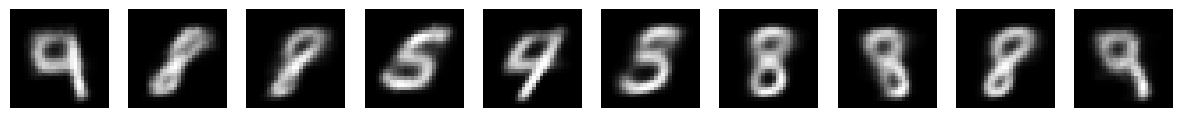

In [25]:
def generate_sample(num_samples=10):
    vae.eval()
    with torch.no_grad():
        # TODO: Sample random latent vectors
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors

        samples = vae.decode(z) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

In [24]:
# %load solutions/sample_gen.py

**Exercise.** As a follow-up exercise, you can check how if the quality of the generated samples improves when using a VAE trained with a larger hidden dimension.

## 6. Interpolation between Images
The objective of this section is to visualize the difference between the space of latent representations and the (original) pixel space. In order to do so, we will perform *image interpolation*, i.e., we will take two random images $x_2$ and $x_2$ from the test set, and interpolate between them: for a given number of interpolation steps $n$, we have:
- In pixel space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by taking, for each pixel, the linear interpolation 
$$\frac{n-t}{n}x_1 + \frac{t}{n}x_2.$$
- In the latent space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by first computing the linear interpolation $z_t$ between the encodings $z_1$ of $x_1$ and $z_2$ of $x_2$, and then decoding $z_t$.

In [ ]:
# TODO: Implement the interpolate_pixel_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_pixel_space(x1, x2)

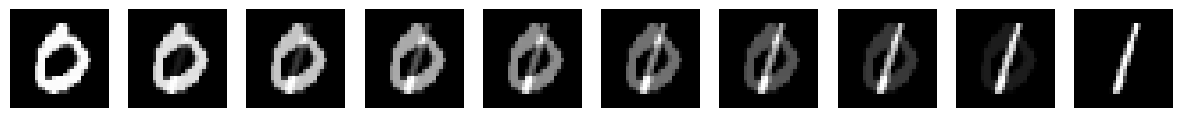

In [27]:
# %load solutions/pixel_interp.py
def interpolate_pixel_space(x1, x2, num_steps=10):
    # Ensure the images are on the same device and have the correct shape
    x1 = x1.view(1, 1, 28, 28).to(device)
    x2 = x2.view(1, 1, 28, 28).to(device)

    # Generate interpolation factors between 0 and 1
    t_values = torch.linspace(0, 1, num_steps).to(device).view(-1, 1, 1, 1)

    # Interpolate directly in pixel space
    interpolated_images = x1 * (1 - t_values) + x2 * t_values

    # Move the images to CPU for visualization
    interpolated_images = interpolated_images.cpu().squeeze(1)  # Remove channel dimension if necessary

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i].squeeze(0), cmap='gray')
        ax[i].axis('off')
    plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_pixel_space(x1, x2)

In [ ]:
# TODO: Implement the interpolate_latent_space function
# the function should take two images as input and the numer of interpolation steps
# and plot the interpolated images in a single row

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_latent_space(x1, x2)

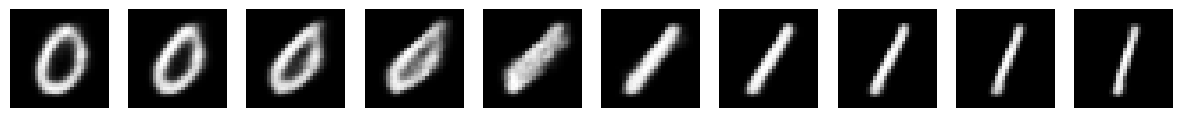

In [33]:
# %load solutions/latent_interp.py
def interpolate_latent_space(x1, x2, num_steps=10):
    vae.eval()
    with torch.no_grad():
        x1, x2 = x1.to(device), x2.to(device)
        mu1, logvar1 = vae.encode(x1.view(1, 1, 28, 28))
        mu2, logvar2 = vae.encode(x2.view(1, 1, 28, 28))

        z1 = vae.sample(mu1, logvar1)
        z2 = vae.sample(mu2, logvar2)

        z = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])
        samples = vae.decode(z).cpu()
        samples = samples.view(num_steps, 1, 28, 28)

        fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
        for i in range(num_steps):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

x1, x2 = test_dataset[3][0], test_dataset[2][0]
interpolate_latent_space(x1, x2)

**Questions.** 
1. How is the interpolation process any different?
2. Are the first and last images the same for both interpolation processes? Why?

## 7. Visualizing the latent space
The objective of this section is to visualize the latent space and to see how it changes according to which term in the loss function we give more weight to.

In [30]:
# Rewrite loss function to return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 183.9096, BCE: 179.3407, KLD: 4.5689
Epoch 2: Average Loss: 159.5622, BCE: 154.2762, KLD: 5.2859
Epoch 3: Average Loss: 155.9640, BCE: 150.3955, KLD: 5.5685
Epoch 4: Average Loss: 153.9412, BCE: 148.2026, KLD: 5.7387
Epoch 5: Average Loss: 152.3968, BCE: 146.5373, KLD: 5.8595
Epoch 6: Average Loss: 150.9885, BCE: 145.0650, KLD: 5.9236
Epoch 7: Average Loss: 150.1766, BCE: 144.2046, KLD: 5.9719
Epoch 8: Average Loss: 149.3250, BCE: 143.2968, KLD: 6.0282
Epoch 9: Average Loss: 148.4154, BCE: 142.3370, KLD: 6.0783
Epoch 10: Average Loss: 147.9131, BCE: 141.7982, KLD: 6.1149


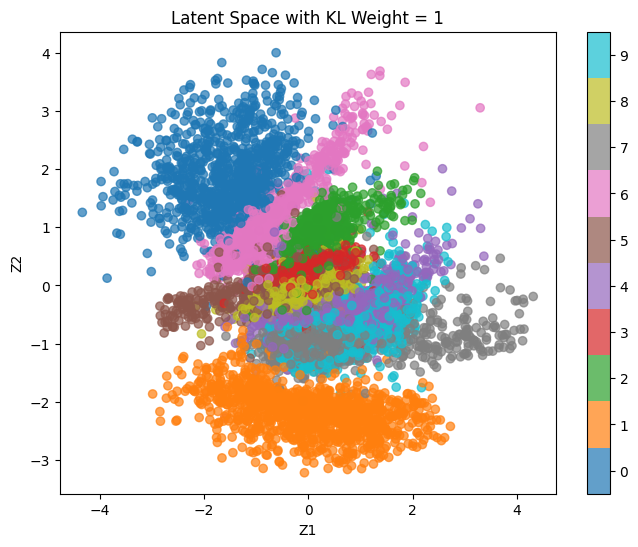


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 206.7562, BCE: 193.1118, KLD: 1.3644
Epoch 2: Average Loss: 192.0993, BCE: 173.1087, KLD: 1.8991
Epoch 3: Average Loss: 190.7136, BCE: 170.3841, KLD: 2.0329
Epoch 4: Average Loss: 190.0273, BCE: 168.7532, KLD: 2.1274
Epoch 5: Average Loss: 189.4603, BCE: 167.4531, KLD: 2.2007
Epoch 6: Average Loss: 188.9904, BCE: 166.0511, KLD: 2.2939
Epoch 7: Average Loss: 188.4798, BCE: 165.1534, KLD: 2.3326
Epoch 8: Average Loss: 188.0955, BCE: 164.2651, KLD: 2.3830
Epoch 9: Average Loss: 187.6817, BCE: 163.5688, KLD: 2.4113
Epoch 10: Average Loss: 187.5224, BCE: 163.0124, KLD: 2.4510


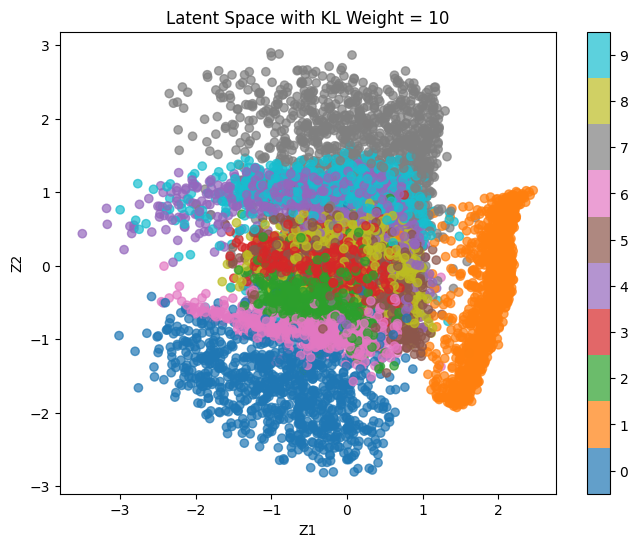


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 217.1761, BCE: 215.1043, KLD: 0.0207
Epoch 2: Average Loss: 206.5280, BCE: 206.4400, KLD: 0.0009
Epoch 3: Average Loss: 206.3931, BCE: 206.3248, KLD: 0.0007
Epoch 4: Average Loss: 206.3147, BCE: 206.2577, KLD: 0.0006
Epoch 5: Average Loss: 206.2767, BCE: 206.2156, KLD: 0.0006
Epoch 6: Average Loss: 206.2702, BCE: 206.2070, KLD: 0.0006
Epoch 7: Average Loss: 206.2363, BCE: 206.1799, KLD: 0.0006
Epoch 8: Average Loss: 206.2384, BCE: 206.1747, KLD: 0.0006
Epoch 9: Average Loss: 206.2197, BCE: 206.1688, KLD: 0.0005
Epoch 10: Average Loss: 206.2189, BCE: 206.1553, KLD: 0.0006


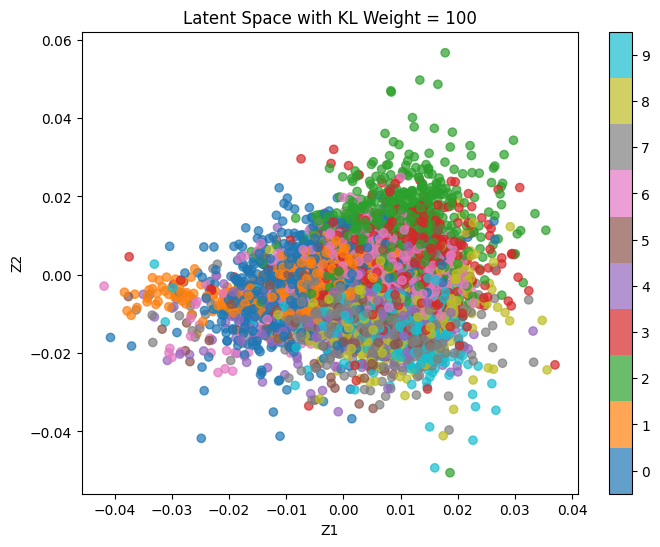

In [31]:
# Hyperparameters
latent_dims = 2
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

# Training and plotting function
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data)
            loss, bce, kld = loss_function(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Plot latent space
    plot_latent_space(model, kl_weight)

# Function to plot latent space
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        mu, logvar = model.encode(data)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.numpy()
        
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)


**Question.** 
1. Describe is the effect of the KL weight $\beta$ on the latent space.
2. Explain why the described effect happens, and link it with the objective of each of the terms in the loss function.
